In [ ]:
import sys
sys.path.append('../scripts')

from nrel_eagle_data_preprocessing import preprocess_data
from ml_model_training import train_model_per_cluster, test_model_per_cluster
from baseline_xgboost import train_eagle_xgboost, test_eagle_xgboost
from kmeans_clustering import create_sub_dataframes

# Standard Libraries
import os
import sys
import datetime
from datetime import timedelta

# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Plotting and Visualization
import matplotlib.pyplot as plt




# Data Preprocessing

In [ ]:
file_path = "../data/nrel-eagle/eagle_data.csv.bz2"
df, df_failure = preprocess_data(file_path)
print("Data preprocessing complete!")
print(f"Number of successful jobs: {len(df)}")
print(f"Number of failed jobs: {len(df_failure)}")


In [ ]:
df

# Train-Test Split

In [ ]:
start_time = '2018-11-14'
end_time = '2023-02-01'

window_size = 90
update_frequency = '1M'




In [ ]:
start_dates = pd.date_range(start=start_time, end=end_time, freq=update_frequency)
end_dates = start_dates + pd.DateOffset(days=window_size)

date_pairs = list(zip(start_dates, end_dates))


In [ ]:
train_features = ['wallclock_req','processors_req','mem_req','nodes_req','gpus_req','user','partition','name','account']
target_feature = 'run_time'    
user_req_feature = 'wallclock_req'  
#bias_types = ['mean', 'mad', 'std_dev', 'two_sigma']
bias_types = ['none','mean', 'mad', 'std_dev', 'two_sigma']

df['end_time'] = pd.to_datetime(df['end_time'])
                                   

In [ ]:
print(f"0 values count: {(df[target_feature] == 0).sum()}")



# Execution Time Prediction Experiments

In [ ]:
# Train and test the baseline model for each window
for start_date, end_date in date_pairs:
    
    df_slice = df[(df['end_time'] >= start_date) & (df['end_time'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)
    df_slice = df_slice.replace([np.inf, -np.inf], np.nan).dropna()

    model, biases = train_eagle_xgboost(train_df, train_features, target_feature)
    
    for bias_type in bias_types:
        test_eagle_xgboost(test_df, model, biases, bias_type, train_features, target_feature, user_req_feature, f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/eagle/obj_changed/window_size={window_size}/eagle_baseline_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl')
   


In [ ]:
for start_date, end_date in date_pairs:
    
    print(f"START DATE: {start_date}")
    
    df_slice = df[(df['end_time'] >= start_date) & (df['end_time'] < end_date)]
    df_slice = df_slice.replace([np.inf, -np.inf], np.nan)
    df_slice = df_slice.dropna()
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    print("[INFO] Creating sub-dataframes and clustering...")
    sub_dataframes, cluster_centers = create_sub_dataframes(
        df=train_df, 
        selected_features=train_features, 
        n_clusters=18 
    )


    print("[INFO] Training plain models (XGBoost and RandomForest)...")
    xgb_plain_models, xgb_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost')
    rf_plain_models, rf_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf')
    print("[INFO] Plain models training completed.")


    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_plain_models, xgb_plain_biases, bias_type,
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/eagle/obj_changed/window_size={window_size}/eagle_clustering_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_plain_models, rf_plain_biases, bias_type, 
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/eagle/obj_changed/window_size={window_size}/eagle_clustering_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )


    print("[INFO] Training resampled models (XGBoost and RandomForest)...")
    xgb_resampled_models, xgb_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost',resampling=True)
    rf_resampled_models, rf_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf',resampling=True)
    print("[INFO] Resampled models training completed.")
    
    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_resampled_models, xgb_resampled_biases, bias_type,
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/eagle/obj_changed/window_size={window_size}/eagle_resampled_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_resampled_models, rf_resampled_biases, bias_type, 
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/eagle/obj_changed/window_size={window_size}/eagle_resampled_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        ) 
        

# Observe Predictions

In [2]:
import os

start_time = '2018-11-14'
end_time = '2023-02-01'

start_dates = pd.date_range(start=start_time, end=end_time, freq='7D')
window_sizes = [7, 14]

target_feature = 'run_time' 
models = ['baseline', 'clustering_xgb','clustering_rf', 'resampled_xgb', 'resampled_rf']


bias_types = ['none', 'two_sigma']

results = {}

for start_date in start_dates:
    results[start_date] = {}
    
    for window_size in window_sizes:
        results[start_date][window_size] = {}

        for model in models:
            results[start_date][window_size][model] = {}

            for bias_type in bias_types:
                results[start_date][window_size][model][bias_type] = {}

                file_path = f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/eagle/obj_changed/window_size={window_size}/eagle_{model}_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl' 
                if os.path.exists(file_path):
                    results[start_date][window_size][model][bias_type] = pd.read_pickle(file_path) 
  
                else:
                    print(f"Error: The file {file_path} was not found.")
    
    
start_dates = pd.date_range(start=start_time, end=end_time, freq='1M')
window_sizes = [30, 60, 90]

for start_date in start_dates:
    results[start_date] = {}
    
    for window_size in window_sizes:
        results[start_date][window_size] = {}

        for model in models:
            results[start_date][window_size][model] = {}

            for bias_type in bias_types:
                results[start_date][window_size][model][bias_type] = {}

                file_path = f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/eagle/obj_changed/window_size={window_size}/eagle_{model}_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl' 
                results[start_date][window_size][model][bias_type] = pd.read_pickle(file_path) 
                
              



In [3]:
models = ['baseline', 'clustering_xgb', 'clustering_rf', 'resampled_xgb', 'resampled_rf']
bias_types = ['none', 'two_sigma']
start_dates = pd.date_range(start=start_time, end=end_time, freq='1M')


for model in models:
    for bias in bias_types:
        total_underpred = 0
        total_jobs = 0
        total_user_req = 0
        total_pred = 0
        
        for start_date in start_dates:
            df = results[start_date].get(30, {}).get(model, {}).get(bias)
            if df is None:
                continue

            df = df.copy()
            
            underpredictions = df[df['pred'] < df['act']]
            total_underpred += len(underpredictions)
            total_jobs += len(df)

            user_overpred = df[df['act'] < df['req']]
            total_user_req += (user_overpred['req'] - user_overpred['act']).sum()

            overpred = df[df['act'] < df['pred']]
            total_pred += (overpred['pred'] - overpred['act']).sum()


        # Compute success and underprediction ratios
        if total_jobs > 0:
            success_rate = 100 * (1 - total_underpred / total_jobs)
            underpred_ratio = 100 * (total_underpred / total_jobs)
        else:
            success_rate = 0
            underpred_ratio = 0

        print(f"For Model {model}, Bias {bias}:")
        print(f" - Underprediction Ratio: {underpred_ratio:.2f}%")



For Model baseline, Bias none:
 - Underprediction Ratio: 50.16%
For Model baseline, Bias two_sigma:
 - Underprediction Ratio: 1.37%
For Model clustering_xgb, Bias none:
 - Underprediction Ratio: 49.31%
For Model clustering_xgb, Bias two_sigma:
 - Underprediction Ratio: 3.80%
For Model clustering_rf, Bias none:
 - Underprediction Ratio: 40.89%
For Model clustering_rf, Bias two_sigma:
 - Underprediction Ratio: 2.86%
For Model resampled_xgb, Bias none:
 - Underprediction Ratio: 42.35%
For Model resampled_xgb, Bias two_sigma:
 - Underprediction Ratio: 4.70%
For Model resampled_rf, Bias none:
 - Underprediction Ratio: 37.66%
For Model resampled_rf, Bias two_sigma:
 - Underprediction Ratio: 4.65%


In [4]:
plot_data = []

for start_date, window_dict in results.items():
    for window_size, model_dict in window_dict.items():
        for model, bias_dict in model_dict.items():
            for bias, df in bias_dict.items():
                if df is not None and 'pred' in df.columns and 'act' in df.columns:
                
                    rmse = np.sqrt(np.mean((df['pred'] - df['act']) ** 2))
                    mae = np.mean(np.abs(df['pred'] - df['act']))

                    underpredictions = df[df['pred'] < df['act']]
                    num_underpredictions = len(underpredictions)
                    total_predictions = len(df)
                    underpred_ratio = 100 * num_underpredictions / total_predictions

                    # Compute the mean and std dev of underprediction amounts
                    underpred_amounts = (underpredictions['act'] - underpredictions['pred'])
                    total_underpred_amount = underpred_amounts.sum() / 3600
                    mean_underpred_amount = underpred_amounts.mean() / 3600
                    std_underpred_amount = underpred_amounts.std() / 3600

                    plot_data.append({
                        'Window Size': window_size, 
                        'Model': model, 
                        'Bias': bias, 
                        'RMSE': rmse, 
                        'MAE': mae, 
                        'UR': underpred_ratio, 
                        'UR_total(hours)': total_underpred_amount,
                        'UR_mean(hours)': mean_underpred_amount, 
                        'UR_std(hours)': std_underpred_amount
                    })
                
                else:
                    print(f"  Skipping Model: {model} due to missing columns")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)


average_metrics = plot_df.groupby(['Window Size', 'Model', 'Bias']).mean().reset_index()


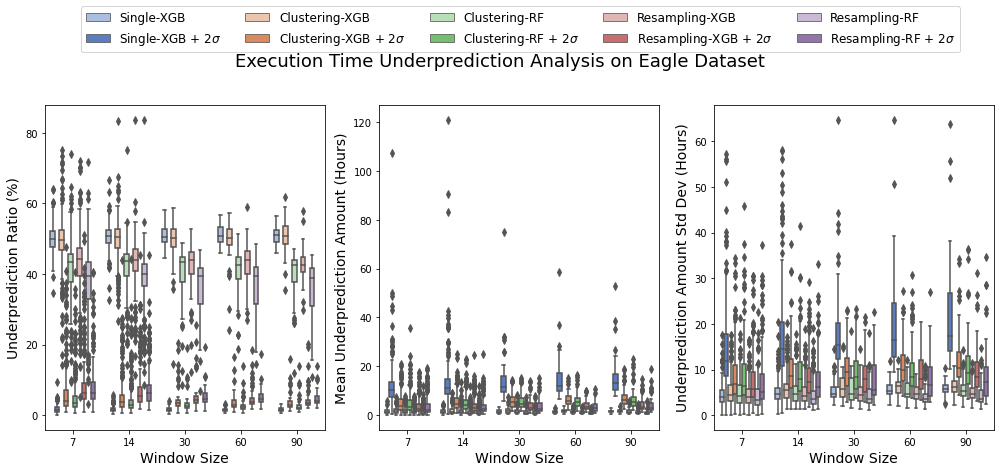

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

base_colors = sns.color_palette("muted", 5)

lighter_colors = [mcolors.to_rgb(c) for c in base_colors]
lighter_colors = [(r + 0.5*(1-r), g + 0.5*(1-g), b + 0.5*(1-b)) for r, g, b in lighter_colors]
custom_palette = [color for pair in zip(lighter_colors, base_colors) for color in pair]

plot_df["Model_Bias"] = plot_df["Model"] + " - " + plot_df["Bias"]

custom_labels = {
    'baseline - none': 'Single-XGB',
    'baseline - two_sigma': r'Single-XGB + $2\sigma$',
    'clustering_xgb - none': 'Clustering-XGB',
    'clustering_xgb - two_sigma': r'Clustering-XGB + $2\sigma$',
    'clustering_rf - none': 'Clustering-RF',
    'clustering_rf - two_sigma': r'Clustering-RF + $2\sigma$',
    'resampled_xgb - none': 'Resampling-XGB',
    'resampled_xgb - two_sigma': r'Resampling-XGB + $2\sigma$',
    'resampled_rf - none': 'Resampling-RF',
    'resampled_rf - two_sigma': r'Resampling-RF + $2\sigma$',
}

fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[0]
)
axes[0].set_xlabel("Window Size", fontsize=14)
axes[0].set_ylabel("Underprediction Ratio (%)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_mean(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[1]
)
axes[1].set_xlabel("Window Size", fontsize=14)
axes[1].set_ylabel("Mean Underprediction Amount (Hours)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_std(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[2]
)
axes[2].set_xlabel("Window Size", fontsize=14)
axes[2].set_ylabel("Underprediction Amount Std Dev (Hours)", fontsize=14)



fig.suptitle("Execution Time Underprediction Analysis on Eagle Dataset", fontsize=18)

handles, labels = axes[0].get_legend_handles_labels()

custom_labels_list = [custom_labels.get(label, label) for label in labels]

fig.legend(handles, custom_labels_list, loc='upper center', bbox_to_anchor=(0.52, 1.1), ncol=5, fontsize=12)

axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])

plot_name = 'boxplot_eagle.svg'
file_path = os.path.join('/projectnb/peaclab-mon/boztop/resource-allocation/plots', plot_name)
plt.savefig(file_path, format="svg", dpi=300, bbox_inches='tight')

plt.show()


In [6]:
start_dates = pd.date_range(start=start_time, end=end_time, freq='7D')

for model in models:
    total_user_req = 0
    total_pred = 0
    
    for start_date in start_dates:
        df = results[start_date].get(7, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
            
        df = df.copy()
        
        user_overpred = df[df['act'] < df['req']].copy()
        total_user_req += (user_overpred['req']  - user_overpred['act']).sum()
        
        overpred = df[df['act'] < df['pred']].copy()
        total_pred += (overpred['pred']  - overpred['act']).sum()
        
    print(f"Model: {model}")
    print(f"Total user request overprediction (hours): {total_user_req/3600}")
    print(f"Total model overprediction (hours): {total_pred/3600}")
        
        

    



Model: baseline
Total user request overprediction (hours): 15320048.491944445
Total model overprediction (hours): 11535701.337909766
Model: clustering_xgb
Total user request overprediction (hours): 15191727.501944445
Total model overprediction (hours): 6711741.517175358
Model: clustering_rf
Total user request overprediction (hours): 15191727.501944445
Total model overprediction (hours): 7624622.411468491
Model: resampled_xgb
Total user request overprediction (hours): 15191727.501944445
Total model overprediction (hours): 5229110.362334624
Model: resampled_rf
Total user request overprediction (hours): 15191727.501944445
Total model overprediction (hours): 6014660.887960517


In [ ]:
# Visualize underprediction distribution
start_dates = pd.date_range(start=start_time, end=end_time, freq='1M')

models = ['baseline', 'clustering_rf', 'resampled_rf']
name_mapping = {
    "baseline": "Single-XGB",
    "clustering_rf": "Clustering-RF",
    "resampled_rf": "Resampling-RF"
}

fig, axes = plt.subplots(1, len(models), figsize=(18, 6), sharey=True)

bounds = [0, 60*60, 60*60*6, 60*60*12, 60*60*24, 60*60*24*2]
#colors = plt.cm.plasma(np.linspace(0, 1, len(bounds) - 1))
colors = sns.color_palette("muted", len(bounds))

line_colors = colors.copy()



for ax, model in zip(axes, models):
    ax.set_title(f"{name_mapping.get(model, model)} Error Distribution", fontsize=20)
    median_errors = {bound: [] for bound in bounds[:-1]}  # Store median errors for each bin
    total_underpred = 0
    total_jobs = 0

    for start_date in start_dates:
        df = results[start_date].get(30, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
        df = df.copy()
        underpredictions = df[df['pred'] < df['act']].copy()
        total_underpred = total_underpred + len(underpredictions)
        total_jobs = total_jobs +  len(df)
        df.loc[:, 'error'] = df['act'] - df['pred']
        df.loc[:, 'abs_error'] = abs(df['error'])
        
        for i, bound in enumerate(bounds[:-1]):
            l_bound = bound
            r_bound = bounds[i + 1]
            color = colors[i]
            line_color = line_colors[i]

            error_sample = df[df.act.between(l_bound, r_bound, inclusive='right')].abs_error / 60
            ax.hist(error_sample, bins=np.logspace(-3, 4, 50), color=color, alpha=0.8)

            med_err = error_sample.median()
            if not np.isnan(med_err):  # Store median error only if valid
                median_errors[bound].append(med_err)

    # Plot median error lines after processing all start dates
    for i, bound in enumerate(bounds[:-1]):
        if median_errors[bound]:  # If there are valid medians
            med_err_final = np.median(median_errors[bound])  # Take median of medians
            med_err_label = 'mins'
            if med_err_final > 60:
                med_err_final /= 60
                med_err_label = 'hours'

            # Format bounds label
            bound_label = '('
            for bound in (bounds[i], bounds[i + 1]):
                if bound < 60*60:
                    new_bound = f"{bound//60}m"
                elif bound < 60*60*24:
                    new_bound = f"{bound//(60*60)}h"
                else:
                    new_bound = f"{bound//(24*60*60)}d"
                bound_label += f"{new_bound}, "
            bound_label = bound_label[:-2] + ']'

            ax.vlines(med_err_final, 0, 250000, linestyle='--', color=line_colors[i], 
                      label=f'{bound_label} Med Err: {med_err_final:.1f} {med_err_label}')
    
    print(f"For Model {model}, there are {total_jobs} total jobs.\n")
    print(f"For Model {model}, there are {total_underpred} total underpredictions.\n")
    print(f"Success rate is, {100 * (1-total_underpred/total_jobs)}\n") 
    
    ax.set_xscale('log')
    ax.set_xlim(0.1, 10000)
    ax.set_ylim([0, 80000])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.legend(loc='upper left', prop={'family': 'DejaVu Sans Mono', 'size': 14})
    if ax == axes[0]:
        ax.set_ylabel('Number of Jobs',fontsize=20)
    ax.grid(True)    

fig.text(0.5, -0.02, 'Absolute Error (minutes)', ha='center', fontsize=20)
plt.suptitle(r'Execution Time Absolute Error Results on Eagle Dataset (with 2$\sigma$ buffer)', y=1, fontsize=22)
plt.tight_layout()
plot_name = 'mae_dist_eagle.svg'
file_path = os.path.join('/projectnb/peaclab-mon/boztop/resource-allocation/plots', plot_name)
plt.savefig(file_path, format="svg", dpi=300, bbox_inches='tight')
plt.show()


For Model baseline, there are 1446996 total jobs.

For Model baseline, there are 19836 total underpredictions.

Success rate is, 98.62915999767795

For Model clustering_rf, there are 1425262 total jobs.

For Model clustering_rf, there are 40757 total underpredictions.

Success rate is, 97.14038541685669

For Model resampled_rf, there are 1425262 total jobs.

For Model resampled_rf, there are 66223 total underpredictions.

Success rate is, 95.35362621047919



# Some Visuals

In [ ]:
# LET'S VISUALIZE THE OVERPREDICTION FOR THE EXECUTION TIME
plt.figure(figsize=(10, 6))

# Ensure the columns are numeric
df['wallclock_req'] = pd.to_numeric(df['wallclock_req'], errors='coerce')
df['run_time'] = pd.to_numeric(df['run_time'], errors='coerce')

random_indices = np.random.choice(np.arange(len(df)), size=100, replace=False)
random_indices_sorted = np.sort(random_indices)


plt.scatter(df['wallclock_req'].iloc[random_indices_sorted].index, 
            df['wallclock_req'].iloc[random_indices_sorted], 
            label='User Requested Execution Time', marker='o', color='#FF4500')

plt.scatter(df['run_time'].iloc[random_indices_sorted].index, 
            df['run_time'].iloc[random_indices_sorted], 
            label='Actual Execution Time', marker='x', color='purple')

plt.title('Comparing the Execution Time Requests with Actual Results (NREL Eagle Dataset)')
plt.xlabel('Job Index')
plt.ylabel('Seconds')

plt.legend()

save_path = '/projectnb/peaclab-mon/boztop/resource-allocation/plots/nrel_eagle_exec_time.png'  # Change this to your desired path
plt.savefig(save_path)

plt.show()


In [ ]:
# Demonstrating the queue wait time increases with increasing wait time

df_success = df.copy()

bins = [0, 0.1, 1, 10, 20, 100, 200, float('inf')]
labels = ['[0, 0.1]', '(0.1, 1]', '(1, 10]',  '(10, 20]',  '(20, 100]', '(100, 200]', '(200, ∞)']

bins = [0, 10, 60, 120, 240, 480, 960, 1440, 2880, 5760, 11520, 23040]  # In minutes
labels = ['0-10min', '10min-1hr', '1hr-2hrs', '2hrs-4hrs', '4hrs-8hrs', 
          '8hrs-16hrs', '16hrs-1day', '1day-2days', '2days-4days', '4days-8days', '8days-16days']
    
df_success['wallclock_req_hour'] = df_success['wallclock_req'] / 60
df_success['wait_time_hour'] = df_success['wait_time'] / 3600


df_success['wallclock_category'] = pd.cut(df_success['wallclock_req_hour'], bins=bins, labels=labels)

wait_time_means = df_success.groupby('wallclock_category')['wait_time_hour'].mean()

plt.figure(figsize=(10, 6))
wait_time_means.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Requested Wallclock Time (hours)', fontsize=20)
plt.ylabel('Average Wait Time (hours)',fontsize=20)
plt.title('Eagle Dataset Average Wait Time by Requested Wallclock Time',fontsize=20)
plt.yticks(fontsize=14)
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)
plt.xticks(fontsize=16)
plt.show()




# User Variance Study

In [ ]:
zero_runtime_count = df_success[df_success['run_time'] == 0].shape[0]

# Print the result
print(f"Number of jobs with run_time == 0: {zero_runtime_count}")

In [ ]:
user_stats = df_success.groupby('user')['run_time'].agg(['count', 'mean', 'std']).reset_index()
user_stats = user_stats.rename(columns={'count': 'job_count', 'mean': 'avg_runtime', 'std': 'runtime_std'})

top_20_users = user_stats.nlargest(20, 'job_count')

plt.figure(figsize=(12, 6))
plt.bar(top_20_users['user'], top_20_users['job_count'], yerr=top_20_users['runtime_std'], capsize=5)
plt.xticks(rotation=45, ha='right')
plt.xlabel('User')
plt.ylabel('Number of Jobs Submitted')
plt.title('Top 20 Users by Job Submissions with Runtime Variation')
plt.tight_layout()

plt.show()


In [ ]:
user_stats = df_success.groupby('user')['run_time'].agg(job_count='count', min_runtime='min', max_runtime='max').reset_index()

top_20_users = user_stats.nlargest(20, 'job_count')

plt.figure(figsize=(12, 6))
plt.errorbar(
    top_20_users['user'], 
    (top_20_users['min_runtime'] + top_20_users['max_runtime']) / 2,  # Mid-point of min and max for plotting
    yerr=[top_20_users['max_runtime'] - (top_20_users['min_runtime'] + top_20_users['max_runtime']) / 2, 
          (top_20_users['min_runtime'] + top_20_users['max_runtime']) / 2 - top_20_users['min_runtime']],
    fmt='o', capsize=5, color='blue'
)

# Step 4: Add job count as text labels on top of each error bar
for i, (user, job_count) in enumerate(zip(top_20_users['user'], top_20_users['job_count'])):
    plt.text(i, top_20_users['max_runtime'].iloc[i] + 1, str(job_count), ha='center', va='bottom', fontsize=10)

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('User')
plt.ylabel('Runtime (min-max)')
plt.title('Top 20 Users by Job Submissions with Min-Max Runtime and Job Counts')
plt.tight_layout()

plt.show()


In [ ]:

# Step 1: Calculate job count, min, max, and variance of runtime for each user
user_stats = df_success.groupby('user')['run_time'].agg(
    job_count='count', min_runtime='min', max_runtime='max', runtime_variance='var'
).reset_index()

# Step 2: Select the top 20 users by runtime variance
top_20_users = user_stats.nlargest(20, 'runtime_variance')

# Step 3: Plot min-max runtime as error bars with job counts as labels
plt.figure(figsize=(12, 6))
plt.errorbar(
    top_20_users['user'], 
    (top_20_users['min_runtime'] + top_20_users['max_runtime']) / 2,  # Mid-point of min and max for plotting
    yerr=[top_20_users['max_runtime'] - (top_20_users['min_runtime'] + top_20_users['max_runtime']) / 2, 
          (top_20_users['min_runtime'] + top_20_users['max_runtime']) / 2 - top_20_users['min_runtime']],
    fmt='o', capsize=5, color='blue'
)

# Step 4: Add job count as text labels on top of each error bar
for i, (user, job_count) in enumerate(zip(top_20_users['user'], top_20_users['job_count'])):
    plt.text(i, top_20_users['max_runtime'].iloc[i] + 1, str(job_count), ha='center', va='bottom', fontsize=10)

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('User')
plt.ylabel('Runtime (min-max)')
plt.title('Top 20 Users by Runtime Variation with Min-Max Runtime and Job Counts')
plt.tight_layout()

plt.show()


In [ ]:
def calculate_variance(df, target_column):
    stats = df.groupby('user')[target_column].var().reset_index(name='Variance')
    return stats

df_filtered = df_success[df_success['run_time'] != 0]

job_counts = df_filtered.groupby('user').size().reset_index(name='job_count')

bins = [0, 5, 20, 50, 100, 250, 500, 1000, 2500, job_counts['job_count'].max()]
labels = ['1-5', '6-20', '21-50', '51-100', '101-250', '251-500', '501-1000', '1001-2500', '2500+']
job_counts['job_range'] = pd.cut(job_counts['job_count'], bins=bins, labels=labels, right=False)

variance_stats = calculate_variance(df_filtered, 'run_time')

job_counts = job_counts.merge(variance_stats, on='user')

job_counts = job_counts.dropna(subset=['Variance'])

range_distribution = job_counts['job_range'].value_counts(normalize=True).sort_index() * 100

avg_variance_by_range = job_counts.groupby('job_range')['Variance'].mean()

# Plot the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range_distribution.index, range_distribution.values, color='purple')
plt.xlabel('Number of Jobs Submitted (Range)')
plt.ylabel('Percentage of Users (%)')
plt.title('Percentage of Users by Job Submission Range')

# Add percentage labels on top of bars
for bar, pct in zip(bars, range_distribution.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10, color='black')

# Display average variance values above each bar
for i, bar in enumerate(bars):
    avg_variance = avg_variance_by_range.iloc[i]
    # Format the variance with 3 significant figures in scientific notation
    formatted_variance = f'{avg_variance:.3e}'
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
             f'Avg Var: {formatted_variance}', ha='center', va='bottom', fontsize=10, color='blue')

# Display the plot
plt.tight_layout()
plt.show()

# Print the average variance by job submission range
print("Average run_time variance by job submission range:")
print(avg_variance_by_range)


# Execution time variation for users

In [ ]:
def calculate_user_variation(df, user, target_columns, plot_type='scatter'):
    user_df = df[df['user'] == user]
    
    std_devs = {}
    
    for target_column in target_columns:
        std_dev = user_df[target_column].std()
        std_devs[target_column] = std_dev
        print(f"Standard deviation for '{target_column}' for user '{user}': {std_dev}")
    
    plt.figure(figsize=(10, 6))
    
    for target_column in target_columns:
        if plot_type == 'line':
            plt.plot(user_df[target_column], marker='o', linestyle='-', label=target_column)
        elif plot_type == 'scatter':
            plt.scatter(user_df.index, user_df[target_column], label=target_column)
    
    plt.title(f"Variation of Requested and Actual Runtime for User '{user}'")
    plt.xlabel("Index")
    plt.ylabel("Time Values (seconds)")
    plt.legend()
    plt.show()
    
    return std_devs

calculate_user_variation(df_success,'user0314', ['wallclock_req', 'run_time'])


In [ ]:
def calculate_all_users_variation(df, target_column):
    # Step 1: Exclude users with only one entry
    stats = df.groupby('user')[target_column].agg(['std', 'var', 'count']).reset_index()
    stats_filtered = stats[stats['count'] > 1]  # Exclude users with only one entry
    
    if stats_filtered.shape[0] != stats.shape[0]:
        excluded_users = stats[stats['count'] == 1]
        print(f"Users with only one entry (excluded from calculations): {len(excluded_users)}")
        print(excluded_users[['user', 'count']])
    
    # Step 2: Merge the variance statistics back into the original dataframe
    df_with_variance = df.merge(stats_filtered[['user', 'var', 'std']], on='user', how='left')

    # Step 3: Split users into two categories based on variance (5% range)
    variance_5_percent_threshold = stats_filtered['var'].quantile(0.05)
    variance_5_percent_df = df_with_variance[df_with_variance['var'] <= variance_5_percent_threshold]
    remaining_users_df = df_with_variance[df_with_variance['var'] > variance_5_percent_threshold]
    
    # Step 4: Quantile binning for variance range (for visualization)
    quantile_bins = pd.qcut(stats_filtered['var'], q=10, duplicates='drop')
    stats_filtered['variance_range'] = quantile_bins
    
    # Step 5: Distribution of users in each variance range
    range_distribution = stats_filtered['variance_range'].value_counts().sort_index()
    
    # Plot the distribution of users by variance range
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range_distribution.index.astype(str), range_distribution.values, color='teal')
    plt.xlabel('Variance Range')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Users by Run Time Variance Range')

    for bar, count in zip(bars, range_distribution.values):
        percentage = f"{(count / len(stats_filtered) * 100):.1f}%"
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}\n({percentage})', 
                 ha='center', va='bottom', fontsize=10, color='black')

    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.tight_layout()
    plt.show()

    # Return the full dataframes with all features for both categories
    return variance_5_percent_df, remaining_users_df



In [ ]:
variance_5_percent_df, remaining_users_df = calculate_all_users_variation(df_success, 'run_time')



In [ ]:
def calculate_user_variation_by_percentile(df, target_column):
    stats = df.groupby('user')[target_column].agg(['std', 'var', 'count']).reset_index()
    stats_filtered = stats[stats['count'] > 1] 

    if stats_filtered.shape[0] != stats.shape[0]:
        excluded_users = stats[stats['count'] == 1]
        print(f"Users with only one entry (excluded from calculations): {len(excluded_users)}")

    df_with_variance = df.merge(stats_filtered[['user', 'var', 'std']], on='user', how='left')
    
    percentiles = pd.qcut(stats_filtered['var'], q=20, labels=False)
    stats_filtered['variance_percentile'] = percentiles

    percentile_dataframes = []
    for percentile in range(20):
        percentile_df = df_with_variance[df_with_variance['user'].isin(
            stats_filtered[stats_filtered['variance_percentile'] == percentile]['user']
        )].drop(columns=['var', 'std'])  # Drop 'var' and 'std'
        percentile_dataframes.append(percentile_df)

    range_distribution = stats_filtered['variance_percentile'].value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range_distribution.index, range_distribution.values, color='teal')
    plt.xlabel('Variance Percentile')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Users by Run Time Variance Percentile')

    for bar, count in zip(bars, range_distribution.values):
        percentage = f"{(count / len(stats_filtered) * 100):.1f}%"
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}\n({percentage})', 
                 ha='center', va='bottom', fontsize=10, color='black')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return percentile_dataframes


In [ ]:
percentile_dfs = calculate_user_variation_by_percentile(df_success, 'run_time')

In [ ]:
'''
# The time columns are of the ISO 8601 format
df['wallclock_used_seconds'] = df['wallclock_used'].apply(isodate.parse_duration).dt.total_seconds()
df['wallclock_req_seconds'] = df['wallclock_req'].apply(isodate.parse_duration).dt.total_seconds()
df['cpu_used_seconds'] = df['cpu_used'].apply(isodate.parse_duration).dt.total_seconds()
df['queue_wait_seconds'] = df['queue_wait'].apply(isodate.parse_duration).dt.total_seconds()
'''
# The time columns are of datetime format

# Showing correlations wrt user run_time variances

In [ ]:
def process_and_plot_correlation(df, target_column):
    label_encoders = {}
    cols_to_encode = ['job_id', 'user', 'account', 'partition', 'qos', 'name', 'work_dir']
    
    for col in cols_to_encode:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    correlation_matrix = df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix of {target_column} and Other Columns')
    plt.show()
    
    return df, label_encoders

In [ ]:
def calculate_positive_correlations(df, target_column, cols_to_encode=['job_id', 'user', 'account', 'partition', 'qos', 'name', 'work_dir']):
    # Encode categorical columns
    label_encoders = {}
    for col in cols_to_encode:
        if col in df.columns:  # Ensure the column exists in the current dataframe
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    
    # Calculate correlation matrix
    correlation_matrix = df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix of {target_column} and Other Columns')
    plt.show()
    
    # Identify positively correlated features with the target column
    positive_corr_features = correlation_matrix[target_column][correlation_matrix[target_column] > 0].index.tolist()
    positive_corr_features.remove(target_column)  # Remove the target column itself from the list
    
    return positive_corr_features, label_encoders

In [ ]:
processed_df, encoders = process_and_plot_correlation(variance_5_percent_df, 'run_time')

In [ ]:
processed_df, encoders = process_and_plot_correlation(remaining_users_df, 'run_time')

In [ ]:
df_success_encoded, _ = process_and_plot_correlation(df_success, 'run_time')

In [ ]:
def process_all_dataframes(dataframes, target_column):
    positive_correlations_dict = {}
    all_label_encoders = {}

    for i, df in enumerate(dataframes):
        # Process each dataframe and calculate positive correlations
        positive_corr_features, label_encoders = calculate_positive_correlations(df, target_column)
        
        # Store results for each percentile dataframe
        positive_correlations_dict[f'Percentile_{i + 1}'] = positive_corr_features
        all_label_encoders[f'Percentile_{i + 1}'] = label_encoders
    
    return positive_correlations_dict, all_label_encoders


In [ ]:
positive_correlations_dict, all_label_encoders = process_all_dataframes(percentile_dfs, 'run_time')

# 2019 dataset operations

In [ ]:
import re
import pandas as pd
import bz2

In [ ]:
def iso_duration_to_seconds(duration_str):
    match = re.match(r'P(?P<days>\d+)DT(?P<hours>\d+)H(?P<minutes>\d+)M(?P<seconds>\d+)S', duration_str)
    if match:
        days = int(match.group('days'))
        hours = int(match.group('hours'))
        minutes = int(match.group('minutes'))
        seconds = int(match.group('seconds'))

        total_seconds = days * 86400 + hours * 3600 + minutes * 60 + seconds
        return total_seconds
    else:
        raise ValueError("Invalid ISO 8601 duration format")



In [ ]:
df_json = pd.read_json('/projectnb/peaclab-mon/boztop/resource-allocation/datasets/nrel-eagle/eagle_jobs_2019-12.json.bz2', orient='records', compression='bz2', lines=True)

df_json


In [ ]:
# ****** Columns in the json file and feature explanations: ******

# wallclock_used: The total wall-clock time used by the job in ISO 8601 duration format (e.g., "P2DT0H0M8S" means 2 days and 8 seconds).
# nodelist: A list of nodes allocated for the job (e.g., ["r8i0n11", "r8i0n15"]).
# user: The user ID who submitted the job, represented as a unique identifier (e.g., "FB976BF71E5B").
# partition: The partition (or queue) where the job was submitted (e.g., "standard").
# cpu_used: The total CPU time used by the job in ISO 8601 duration format (e.g., "P576DT0H38M24S").
# wallclock_req: The wall-clock time requested for the job in ISO 8601 duration format (e.g., "P2DT0H0M0S").
# submit_time: The time when the job was submitted in ISO 8601 format (e.g., "2020-08-31T05:20:50.000Z").
# processors_req: The number of processors (CPUs) requested for the job (e.g., 288).
# start_time: The time when the job started execution (e.g., "2020-08-31T05:20:54.000Z").
# std_power: The standard power consumption for the job (e.g., 10.025973 watts).
# nodes_req: The number of nodes requested by the job (e.g., 8).
# queue_wait: The total time the job spent waiting in the queue before starting, in ISO 8601 duration format (e.g., "P0DT0H0M4S").
# state: The final state of the job (e.g., "TIMEOUT" for jobs that timed out).
# qos: The Quality of Service (QoS) level for the job, which may affect priority (e.g., "standby").
# script: A unique identifier for the job's submission script (e.g., "A539757FAAEE").
# account: The account under which the job was charged (e.g., "BD8618B13179").
# nodes_used: The number of nodes actually used by the job during execution (e.g., 8).
# end_time: The time when the job ended (e.g., "2020-09-02T05:21:02.000Z").
# job_id: A unique identifier for the job (e.g., 4108812).
# array_pos: The position of the job in an array if it was part of an array job (could be null if not applicable).
# avg_power: The average power consumption by the job (e.g., 394.68008 watts).
# processors_used: The actual number of processors (CPUs) used by the job during execution (e.g., 288).


df_json = df_json.drop(columns = ['array_pos', 'partition', 'submit_time', 'start_time',  'script', 'end_time', 'nodelist'])

df_json['wallclock_used_seconds'] = df_json['wallclock_used'].apply(iso_duration_to_seconds)
df_json['wallclock_req_seconds'] = df_json['wallclock_req'].apply(iso_duration_to_seconds)
df_json['queue_wait_seconds'] = df_json['queue_wait'].apply(iso_duration_to_seconds)
df_json['cpu_seconds'] = df_json['cpu_used'].apply(iso_duration_to_seconds)

df_json = df_json.drop(columns = ['wallclock_used', 'wallclock_req', 'queue_wait', 'cpu_used'])


In [ ]:
df_json

In [ ]:
# Demonstrating the queue wait time increases with increasing wait time

bins = [0, 0.1, 1, 10, 100, float('inf')]
labels = ['[0, 0.1]', '(0.1, 1]', '(1, 10]', '(10, 100]', '(100, ∞)']

df_success['wallclock_req_hour'] = df_success['wallclock_req'] / 3600
df_success['wait_time_hour'] = df_success['wait_time'] / 3600


df_success['wallclock_category'] = pd.cut(df_success['wallclock_req_hour'], bins=bins, labels=labels)

wait_time_means = df_success.groupby('wallclock_category')['wait_time_hour'].mean()

plt.figure(figsize=(10, 6))
wait_time_means.plot(kind='bar', color='green', edgecolor='black')

# Adding labels and title
plt.xlabel('Requested Wallclock Time (hours)', fontsize=14)
plt.ylabel('Average Wait Time (hours)',fontsize=14)
plt.title('NREL Eagle: Average Wait Time by Requested Wallclock Time',fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_json['user_encoded'] = label_encoder.fit_transform(df_json['user'])
df_json['account_encoded'] = label_encoder.fit_transform(df_json['account'])


In [ ]:
# --- LET'S MAKE SOME OBSERVATIONS! ---
print(f"Total number of jobs in the dataset: {df_json.shape[0]}")

print(f"Number of unique users: {df_json['user_encoded'].nunique()}")
      
print(f"Number of unique state of jobs: {df_json['state'].nunique()}")  
      
print("The unique state of jobs:")  
      
print(df_json['state'].value_counts())
      
print("The unique qos of jobs:")  
      
print(df_json['qos'].value_counts())

    
df_json_success = df_json[df_json['state'] == 'COMPLETED']
df_json_failure = df_json[df_json['state'] == 'FAILED']       

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, name):
    plt.figure(figsize=(10, 8))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Matrix Heatmap for {name} Jobs in Eagle Dataset")
    plt.show()
     

In [ ]:
plot_correlation_heatmap(df_json_success, 'Successful') 

In [ ]:
plot_correlation_heatmap(df_json_failure, 'Failed') 

In [ ]:
pairs_to_plot = [('nodes_used', 'wallclock_used_seconds'), ('processors_used', 'wallclock_used_seconds'), ('nodes_used', 'processors_used'), ('nodes_req', 'processors_req')]

fig, axes = plt.subplots(1, len(pairs_to_plot), figsize=(12, 5))

for i, (x_col, y_col) in enumerate(pairs_to_plot):
    axes[i].scatter(df_json_success[x_col], df_json_success[y_col], color='b')
    axes[i].set_title(f"{x_col} vs {y_col}")
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# LET'S VISUALIZE THE OVERPREDICTION FOR THE EXECUTION TIME
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))


#random_indices = np.random.choice(df_json_success.index, size=50, replace=False)
#random_indices_sorted = np.sort(random_indices)

random_indices = np.random.randint(0, len(df_json_success), size=100)
random_indices_sorted = np.sort(random_indices[random_indices < len(df_json_success)])


plt.plot(df_json_success['wallclock_req_seconds'].iloc[random_indices_sorted], label='User Requested Execution Time', marker='o', color='#FF4500')
plt.plot(df_json_success['wallclock_used_seconds'].iloc[random_indices_sorted], label='Actual Execution Time', marker='x', color='purple')


plt.title('Comparing the Execution Time Requests with Actual Results (NREL Eagle Dataset)')
plt.xlabel('Job Index')
plt.ylabel('Seconds')


plt.legend()

#save_path = '/projectnb/peaclab-mon/boztop/resource-allocation/plots/nrel_eagle_exec_time.png'  # Change this to your desired path
#plt.savefig(save_path)

plt.show()

# Clustering

In [ ]:
MAX_PROCESSORS_PER_NODE = 36

df_json_success['min_nodes_needed'] = (df_json_success['processors_req'] / MAX_PROCESSORS_PER_NODE).apply(np.ceil)

# Create a new 'group' column based on the nodes requirement comparison
def categorize_row(row):
    if row['nodes_req'] >= row['min_nodes_needed']:
        return 'sufficient_nodes'
    else:
        return 'insufficient_nodes'

df_json_success['group'] = df_json_success.apply(categorize_row, axis=1)

# Drop the helper column if no longer needed
df_json_success.drop(columns=['min_nodes_needed'], inplace=True)

# Output the grouped data
print(df_json_success['group'].value_counts())
print(df_json_success.head())


In [ ]:
highly_correlated_columns = ['cpu_seconds', 'wallclock_req_seconds','nodes_req', 'processors_req','nodes_used', 'processors_used',] 
df_json_success_subset = df_json_success[highly_correlated_columns]

df_json_success_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
df_json_success_subset.fillna(df_json_success_subset.mean(), inplace=True) 

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_json_success['cluster'] = kmeans.fit_predict(df_json_success_subset)

# Output the clustered data
print(df_json_success['cluster'].value_counts())
print(df_json_success.head())

# Training Clusters

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os


features = ['wallclock_req_seconds','nodes_req', 'processors_req','nodes_used', 'processors_used', 'cpu_seconds']
target = 'wallclock_used_seconds'

colors = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white',
    'orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'indigo', 'violet',
    '#FF6347', '#4682B4', '#32CD32', '#FFD700', '#6A5ACD', '#FF4500', '#DA70D6'
]

output_dir = "/projectnb/peaclab-mon/boztop/resource-allocation/plots/"
os.makedirs(output_dir, exist_ok=True)


total_underpredictions = 0
total_overpredictions = 0
total_samples = 0  # To track the total number of samples across clusters


# Loop over each cluster
for cluster_id in df_json_success['cluster'].unique():
    print(f"Training XGBoost for Cluster {cluster_id}")
    
    cluster_data = df_json_success[df_json_success['cluster'] == cluster_id]
    
    X = cluster_data[features]
    y = cluster_data[target]
    wallclock_requests = cluster_data['wallclock_req_seconds']
    
    
    X_train, X_test, y_train, y_test, wallclock_train, wallclock_test = train_test_split(
        X, y, wallclock_requests, test_size=0.2, random_state=42)
    
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Cluster {cluster_id} - Mean Squared Error: {mse}")
    
    # Calculate underpredictions and overpredictions
    underpredictions = (y_pred < y_test).sum()
    underprediction_percentage = (underpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

    overpredictions = (y_pred > y_test).sum()
    overprediction_percentage = (overpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

    print(f"Cluster {cluster_id} - Number of underpredictions: {underpredictions} ({underprediction_percentage:.2f}%)")
    print(f"Cluster {cluster_id} - Number of overpredictions: {overpredictions} ({overprediction_percentage:.2f}%)")

    # Update totals
    total_underpredictions += underpredictions
    total_overpredictions += overpredictions
    total_samples += len(y_test)
    
    # Scatter plot of y_test vs y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color=np.random.choice(colors), label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect prediction line')
    plt.xlabel('Actual Runtime')
    plt.ylabel('Predicted Runtime')
    plt.title(f'Cluster {cluster_id} - Predicted vs Actual Runtime')
    plt.legend()
    plt.grid(True)
    plot_filename = os.path.join(output_dir, f'nrel_eagle_cluster_{cluster_id}_runtime_prediction.png')
    plt.savefig(plot_filename)
    print(f"Figure saved for Cluster {cluster_id}: {plot_filename}")
    plt.show()

    # Wallclock comparison plot
    plt.figure(figsize=(8, 6))
    improvement = wallclock_test - y_pred  # Improvement = requested wallclock - predicted runtime
    plt.scatter(wallclock_test, improvement, color=np.random.choice(colors), label='Improvement')
    plt.axhline(y=0, color='red', linestyle='--', label='No Improvement')
    plt.xlabel('Requested Wallclock Time')
    plt.ylabel('Improvement (Wallclock - Predicted)')
    plt.title(f'Cluster {cluster_id} - Wallclock Time Improvement')
    plt.legend()
    plt.grid(True)
    plot_filename = os.path.join(output_dir, f'nrel_eagle_cluster_{cluster_id}_runtime_improvement.png')
    plt.savefig(plot_filename)
    print(f"Figure saved for Cluster {cluster_id}: {plot_filename}")
    plt.show()
    
if total_samples > 0:
    total_underprediction_percentage = (total_underpredictions / total_samples) * 100
    total_overprediction_percentage = (total_overpredictions / total_samples) * 100
    print(f"\nTotal Number of underpredictions: {total_underpredictions} ({total_underprediction_percentage:.2f}%)")
    print(f"Total Number of overpredictions: {total_overpredictions} ({total_overprediction_percentage:.2f}%)")


# Training the Whole Dataset

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os


features = ['wallclock_req_seconds','nodes_req', 'processors_req','nodes_used', 'processors_used', 'cpu_seconds']
target = 'wallclock_used_seconds'


output_dir = "/projectnb/peaclab-mon/boztop/resource-allocation/plots/"
os.makedirs(output_dir, exist_ok=True)

X = df_json_success[features]
y = df_json_success[target]
wallclock_requests = df_json_success['wallclock_req_seconds']
    
    
X_train, X_test, y_train, y_test, wallclock_train, wallclock_test = train_test_split(
    X, y, wallclock_requests, test_size=0.2, random_state=42)
    
    
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"NREL Eagle Total Dataset Mean Squared Error: {mse}")


underpredictions = (y_pred < y_test).sum()
underprediction_percentage = (underpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

overpredictions = (y_pred > y_test).sum()
overprediction_percentage = (overpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

print(f"NREL Eagle Total Dataset Number of underpredictions: {underpredictions} ({underprediction_percentage:.2f}%)")
print(f"NREL Eagle Total Dataset Number of overpredictions: {overpredictions} ({overprediction_percentage:.2f}%)")

    
    
# Scatter plot of y_test vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color=np.random.choice(colors), label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect prediction line')
plt.xlabel('Actual Runtime')
plt.ylabel('Predicted Runtime')
plt.title(f'NREL Eagle Total Dataset Predicted vs Actual Runtime')
plt.legend()
plt.grid(True)
plot_filename = os.path.join(output_dir, f'nrel_eagle_all_data_runtime_prediction.png')
plt.savefig(plot_filename)
plt.show()

# Wallclock comparison plot
plt.figure(figsize=(8, 6))
improvement = wallclock_test - y_pred  # Improvement = requested wallclock - predicted runtime
plt.scatter(wallclock_test, improvement, color=np.random.choice(colors), label='Improvement')
plt.axhline(y=0, color='red', linestyle='--', label='No Improvement')
plt.xlabel('Requested Wallclock Time')
plt.ylabel('Improvement (Wallclock - Predicted)')
plt.title(f'NREL Eagle Total Dataset Wallclock Time Improvement')
plt.legend()
plt.grid(True)
plot_filename = os.path.join(output_dir, f'nrel_eagle_all_data_runtime_improvement.png')
plt.savefig(plot_filename)
plt.show()
    

In [ ]:
# 3. Visualize Clusters in 2D with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_json_success.drop(columns=['kmeans_cluster']))
df_json_success['pca_one'] = pca_result[:, 0]
df_json_success['pca_two'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_json_success, x='pca_one', y='pca_two', hue='kmeans_cluster', palette="viridis")
plt.title('PCA - Job Submission Clusters')
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def train_and_evaluate_xgboost(df, target, features, output_dir="/projectnb/peaclab-mon/boztop/resource-allocation/plots/"):
    os.makedirs(output_dir, exist_ok=True)
    
    colors = [
        'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white',
        'orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'indigo', 'violet',
        '#FF6347', '#4682B4', '#32CD32', '#FFD700', '#6A5ACD', '#FF4500', '#DA70D6'
    ]
    
    total_underpredictions = 0
    total_overpredictions = 0
    total_samples = 0

    # Loop over each cluster
    for cluster_id in df['kmeans_cluster'].unique():
        print(f"Training XGBoost for Cluster {cluster_id}")
        
        cluster_data = df[df['kmeans_cluster'] == cluster_id]
        
        X = cluster_data[features]
        y = cluster_data[target]
        wallclock_requests = cluster_data['wallclock_req_seconds']
        
        X_train, X_test, y_train, y_test, wallclock_train, wallclock_test = train_test_split(
            X, y, wallclock_requests, test_size=0.2, random_state=42)
        
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        print(f"Cluster {cluster_id} - Mean Squared Error: {mse}")
        
        # Calculate underpredictions and overpredictions
        underpredictions = (y_pred < y_test).sum()
        underprediction_percentage = (underpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

        overpredictions = (y_pred > y_test).sum()
        overprediction_percentage = (overpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

        print(f"Cluster {cluster_id} - Number of underpredictions: {underpredictions} ({underprediction_percentage:.2f}%)")
        print(f"Cluster {cluster_id} - Number of overpredictions: {overpredictions} ({overprediction_percentage:.2f}%)")

        # Update totals
        total_underpredictions += underpredictions
        total_overpredictions += overpredictions
        total_samples += len(y_test)
        
        # Scatter plot of y_test vs y_pred
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, color=np.random.choice(colors), label='Predicted vs Actual')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect prediction line')
        plt.xlabel('Actual Runtime')
        plt.ylabel('Predicted Runtime')
        plt.title(f'Cluster {cluster_id} - Predicted vs Actual Runtime')
        plt.legend()
        plt.grid(True)
        plot_filename = os.path.join(output_dir, f'cluster_{cluster_id}_runtime_prediction.png')
        plt.savefig(plot_filename)
        print(f"Figure saved for Cluster {cluster_id}: {plot_filename}")
        plt.show()

        # Wallclock comparison plot
        plt.figure(figsize=(8, 6))
        improvement = wallclock_test - y_pred  # Improvement = requested wallclock - predicted runtime
        plt.scatter(wallclock_test, improvement, color=np.random.choice(colors), label='Improvement')
        plt.axhline(y=0, color='red', linestyle='--', label='No Improvement')
        plt.xlabel('Requested Wallclock Time')
        plt.ylabel('Improvement (Wallclock - Predicted)')
        plt.title(f'Cluster {cluster_id} - Wallclock Time Improvement')
        plt.legend()
        plt.grid(True)
        plot_filename = os.path.join(output_dir, f'cluster_{cluster_id}_runtime_improvement.png')
        plt.savefig(plot_filename)
        print(f"Figure saved for Cluster {cluster_id}: {plot_filename}")
        plt.show()
    
    if total_samples > 0:
        total_underprediction_percentage = (total_underpredictions / total_samples) * 100
        total_overprediction_percentage = (total_overpredictions / total_samples) * 100
        print(f"\nTotal Number of underpredictions: {total_underpredictions} ({total_underprediction_percentage:.2f}%)")
        print(f"Total Number of overpredictions: {total_overpredictions} ({total_overprediction_percentage:.2f}%)")




In [ ]:
features = ['avg_power','processors_req', 'processors_used', 'nodes_req', 'nodes_used' ]
target = 'wallclock_used_seconds'

train_and_evaluate_xgboost(df_json_success, target, features)

In [ ]:
features = ['avg_power','processors_req', 'processors_used', 'nodes_req', 'nodes_used' ]
target = 'wallclock_used_seconds'

colors = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white',
    'orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'indigo', 'violet',
    '#FF6347', '#4682B4', '#32CD32', '#FFD700', '#6A5ACD', '#FF4500', '#DA70D6'
]
    
output_dir = "/projectnb/peaclab-mon/boztop/resource-allocation/plots/"
os.makedirs(output_dir, exist_ok=True)

X = df_json_success[features]
y = df_json_success[target]
wallclock_requests = df_json_success['wallclock_req_seconds']
    
    
X_train, X_test, y_train, y_test, wallclock_train, wallclock_test = train_test_split(
    X, y, wallclock_requests, test_size=0.2, random_state=42)
    
    
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"NREL Eagle Total Dataset Mean Squared Error: {mse}")


underpredictions = (y_pred < y_test).sum()
underprediction_percentage = (underpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

overpredictions = (y_pred > y_test).sum()
overprediction_percentage = (overpredictions / len(y_test)) * 100 if len(y_test) > 0 else 0

print(f"NREL Eagle Total Dataset Number of underpredictions: {underpredictions} ({underprediction_percentage:.2f}%)")
print(f"NREL Eagle Total Dataset Number of overpredictions: {overpredictions} ({overprediction_percentage:.2f}%)")

    
    
# Scatter plot of y_test vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color=np.random.choice(colors), label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect prediction line')
plt.xlabel('Actual Runtime')
plt.ylabel('Predicted Runtime')
plt.title(f'NREL Eagle Total Dataset Predicted vs Actual Runtime')
plt.legend()
plt.grid(True)
plot_filename = os.path.join(output_dir, f'nrel_eagle_all_data_runtime_prediction.png')
plt.savefig(plot_filename)
plt.show()

# Wallclock comparison plot
plt.figure(figsize=(8, 6))
improvement = wallclock_test - y_pred  # Improvement = requested wallclock - predicted runtime
plt.scatter(wallclock_test, improvement, color=np.random.choice(colors), label='Improvement')
plt.axhline(y=0, color='red', linestyle='--', label='No Improvement')
plt.xlabel('Requested Wallclock Time')
plt.ylabel('Improvement (Wallclock - Predicted)')
plt.title(f'NREL Eagle Total Dataset Wallclock Time Improvement')
plt.legend()
plt.grid(True)
plot_filename = os.path.join(output_dir, f'nrel_eagle_all_data_runtime_improvement.png')
plt.savefig(plot_filename)
plt.show()
    